## Install necessary packages

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
!pip install alphashape
import alphashape

In [4]:
import rasterio
import numpy as np
from tqdm import tqdm
import seaborn as sns
import cv2
from rasterio.mask import mask

In [ ]:
# Make sure to adjust the directories based on where you decide to put this ipynb file.
path_to_data = "full_reforestree_data_dropbox/" 

## Load the field data and visualize it

In [5]:
trees = pd.read_csv('full_reforestree_data_dropbox/field_data.csv')

In [6]:
def get_field_data(site:str, path_to_data:str) -> gpd.GeoDataFrame:
    """
    Loads the field data and creates a GeoDataFrame using the
    provided coordinates as latitude and longitude and filters
    for the provied site.
    """
    field_data = pd.read_csv(path_to_data + "field_data.csv")
    # Create a GeoDataFrame from the longitude and latitude
    geo_field_data = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data.lon, field_data.lat))
    # Just return the data for the provided site
    return geo_field_data.loc[geo_field_data.site==site].copy()

                    name       lat        lon   diameter  height    year  \
2404               Mango -1.198186 -79.591253   4.138019     0.0  2016.0   
2405               Guaba -1.198181 -79.591261   9.549274     0.0  2016.0   
2406             Musacea -1.198177 -79.591197  19.098549     0.0  2016.0   
2407               Guaba -1.198269 -79.591106   9.421951     0.0  2016.0   
2408               Cacao -1.198270 -79.591060   0.000000     0.0  2016.0   
...                  ...       ...        ...        ...     ...     ...   
3328               Cacao -1.198716 -79.591199   0.000000     0.0  2016.0   
3329             Musacea -1.198790 -79.591112  14.960530     0.0  2016.0   
3330               Guaba -1.198859 -79.591054  12.414057     0.0  2016.0   
3331             Musacea -1.198709 -79.591241  11.777438     0.0  2016.0   
3332  Variedad bifurcada -1.198584 -79.591454  16.020155     0.0  2016.0   

     plot_id                     site            X            Y  \
2404      P3  Carlos

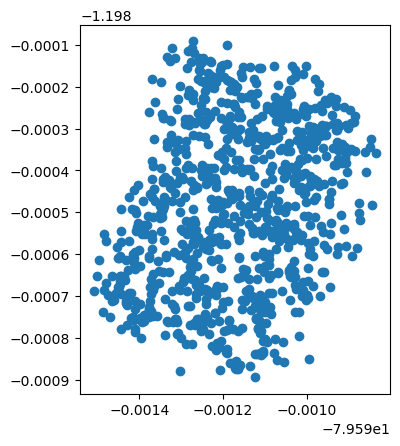

In [8]:
# Define the site and path to data
site = "Carlos Vera Guevara RGB"

field_data = get_field_data(site, path_to_data)
print(field_data)

field_data.plot()
plt.show()

## Generate the alpha shape boundaries

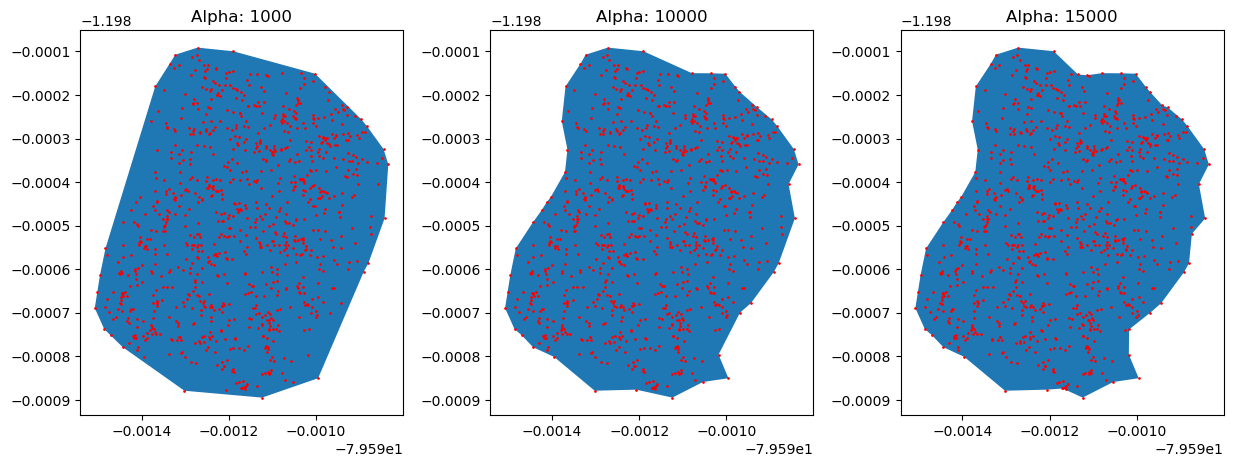

In [9]:
# Call the function to get field data
points = get_field_data(site, path_to_data)[['lon', 'lat']].values

# Define the alpha values
alphas = [1000, 10000, 15000]

# Create a new figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Loop over the alpha values
for i, alpha in enumerate(alphas):
    # Generate the alpha shape
    # What is an alpha shape? https://en.wikipedia.org/wiki/Alpha_shape
    # The alpha-shape associated with a set of points is a generalization of the concept of the convex hull, i.e. every convex hull is an alpha-shape but not every alpha shape is a convex hull.
    alpha_shape = alphashape.alphashape(points, alpha)
    # Create a GeoSeries from the alpha shape
    # What is a GeoSeries? https://geopandas.org/docs/user_guide/data_structures.html#geoseries
    boundary = gpd.GeoSeries({"geometry" : alpha_shape})

    # Plot the alpha shape boundary
    boundary.plot(ax=axs[i])
    
    # Plot the points
    # s controls the size of the points
    # c controls the color of the points
    # points[:,0] is the longitude
    # points[:,1] is the latitude
    axs[i].scatter(points[:,0], points[:,1], c='red',s=0.9)
    
    # Set the title
    axs[i].set_title(f'Alpha: {alpha}')

# Show the plot
plt.show()

## Crop one drone image based on the alpha shape boundary of field data

In [14]:
# Load the .tif image
image_path = f"{path_to_data}wwf_ecuador/RGB Orthomosaics/{site}.tif"

# rasterio.open() is used to open a raster dataset
with rasterio.open(image_path) as src:
    # what is src.read()? https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.BufferedDatasetReader.read
    # We are only reading the first 3 bands of the image, but sadly they are (channels, height, width) instead of (height, width, channels)
    image = src.read([1, 2, 3])
    print(image.shape)
    # in the raster the 3 bands are in this order: channel, height, width, now we are making it height, width, channel
    image = np.moveaxis(image, 0, -1) 
    print(image.shape)
    # Convert field data coordinates to image coordinates
    # as the coordinate system of field data is different than the raster object, we need to convert them
    # the index function find the corresponding point in the raster object from the longitude and latitude of each field data point -> and save them in field_data['row'] and field_data['col']
    field_data['row'], field_data['col'] = src.index(field_data['lon'].values, field_data['lat'].values)

(3, 12305, 12425)
(12305, 12425, 3)


In [15]:
field_data

name       lat        lon   diameter  height    year  \
2404               Mango -1.198186 -79.591253   4.138019     0.0  2016.0   
2405               Guaba -1.198181 -79.591261   9.549274     0.0  2016.0   
2406             Musacea -1.198177 -79.591197  19.098549     0.0  2016.0   
2407               Guaba -1.198269 -79.591106   9.421951     0.0  2016.0   
2408               Cacao -1.198270 -79.591060   0.000000     0.0  2016.0   
...                  ...       ...        ...        ...     ...     ...   
3328               Cacao -1.198716 -79.591199   0.000000     0.0  2016.0   
3329             Musacea -1.198790 -79.591112  14.960530     0.0  2016.0   
3330               Guaba -1.198859 -79.591054  12.414057     0.0  2016.0   
3331             Musacea -1.198709 -79.591241  11.777438     0.0  2016.0   
3332  Variedad bifurcada -1.198584 -79.591454  16.020155     0.0  2016.0   

     plot_id                     site            X            Y  \
2404      P3  Carlos Vera Guevara RGB  5112.448798  2969.787313   
2405      P3  Carlos Vera Guevara RGB  5029.519743  2926.465511   
2406      P3  Carlos Vera Guevara RGB  5678.299687  2888.174627   
2407      P3  Carlos Vera Guevara RGB  6600.389376  3744.083015   
2408      P3  Carlos Vera Guevara RGB  7068.760469  3760.293754   
...      ...                      ...          ...          ...   
3328      P3  Carlos Vera Guevara RGB  5656.015683  7908.752302   
3329      P3  Carlos Vera Guevara RGB  6544.831997  8598.174536   
3330      P3  Carlos Vera Guevara RGB  7136.630014  9241.945839   
3331      P3  Carlos Vera Guevara RGB  5234.349421  7842.046042   
3332      P3  Carlos Vera Guevara RGB  3058.657329  6678.972100   

      updated diameter   group        AGB     carbon  \
2404          4.138019   fruit   3.298619   1.286461   
2405          9.549274   fruit  30.000035  11.700014   
2406         19.098549  banana  16.056542   6.262051   
2407          9.421951   fruit  28.955547  11.292663   
2408          6.843647   cacao   5.444228   2.123249   
...                ...     ...        ...        ...   
3328          6.843647   cacao   5.444228   2.123249   
3329         14.960530  banana   9.544612   3.722399   
3330         12.414057   fruit  59.969747  23.388201   
3331         11.777438  banana   5.734024   2.236270   
3332         16.020155   other  69.819075  27.229439   

                        geometry   row   col  
2404  POINT (-79.59125 -1.19819)  2982  5202  
2405  POINT (-79.59126 -1.19818)  2939  5126  
2406  POINT (-79.59120 -1.19818)  2900  5722  
2407  POINT (-79.59111 -1.19827)  3753  6568  
2408  POINT (-79.59106 -1.19827)  3769  6998  
...                          ...   ...   ...  
3328  POINT (-79.59120 -1.19872)  7901  5701  
3329  POINT (-79.59111 -1.19879)  8588  6517  
3330  POINT (-79.59105 -1.19886)  9229  7060  
3331  POINT (-79.59124 -1.19871)  7835  5314  
3332  POINT (-79.59145 -1.19858)  6676  3317  

[929 rows x 17 columns]

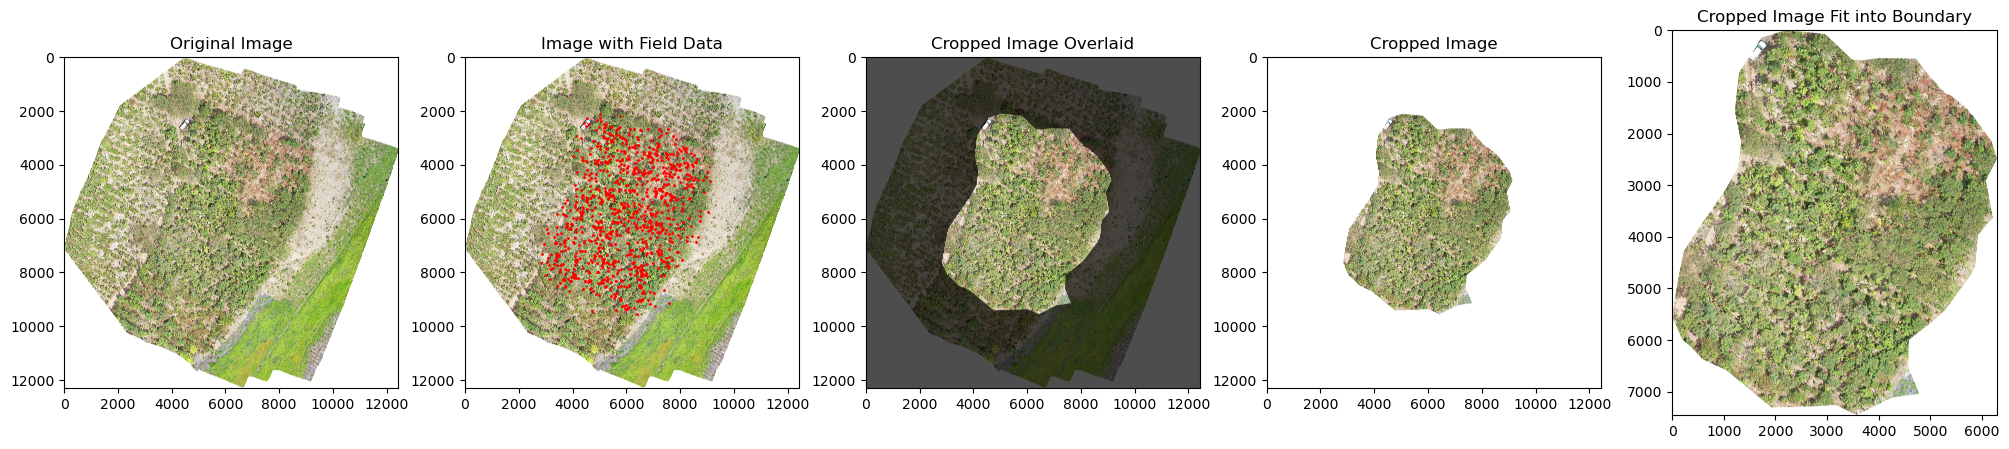

In [16]:
# Generate the alpha shape
points = field_data[['lon', 'lat']].values
alpha_shape = alphashape.alphashape(points, 15000)
boundary = gpd.GeoSeries({"geometry" : alpha_shape})

# Create a new plot
fig, axs = plt.subplots(1, 5, figsize=(25,5))

# Plot the .tif image
axs[0].imshow(image)  # Display the image in its original colors
axs[0].set_title('Original Image')

# Plot the .tif image with field data points
axs[1].imshow(image)  # Display the image in its original colors
# scatter the converted field data points on the image
axs[1].scatter(field_data['col'], field_data['row'], color='red', s=1)  # Plot the field data points
axs[1].set_title('Image with Field Data')

# Plot the cropped image overlaid on the .tif image
with rasterio.open(image_path) as raster:
    # mask() is used to mask the raster with the alpha shape boundary
    # crop=False means that the image will not be cropped to the boundary [We do that later]
    img_cropped, _ = rasterio.mask.mask(raster, boundary, crop=False)
    # move the channels to the last dimension because of the similar reason mentioned earlier that the channels are in the first dimension in raster object, and we need to send it to the last dimension
    img_cropped = np.moveaxis(img_cropped, 0,-1)[:,:,:3]
axs[2].imshow(image)
# alpha controls the transparency of the overlaid image
axs[2].imshow(img_cropped, alpha=0.7)  # Displaying the cropped image with some transparency meaning that you can see the first image a little bit
axs[2].set_title('Cropped Image Overlaid')

# Plot the cropped image
# changing the black pixels to white
img_cropped[img_cropped == 0] = 255  # Change black pixels to white
axs[3].imshow(img_cropped)  # Display the cropped image
axs[3].set_title('Cropped Image')

# Calculate bounding box of non-white pixels
rows = np.any(img_cropped != [255, 255, 255], axis=(1, 2))
cols = np.any(img_cropped != [255, 255, 255], axis=(0, 2))
# get the minimum and maximum values of the rows and columns
rmin, rmax = np.where(rows)[0][[0, -1]]
cmin, cmax = np.where(cols)[0][[0, -1]]

# Crop the image based on the bounding box
img_cropped_bounded = img_cropped[rmin:rmax+1, cmin:cmax+1, :]

# Plot the cropped image fit into the bounding box
axs[4].imshow(img_cropped_bounded)  # Display the cropped image fit into the bounding box
axs[4].set_title('Cropped Image Fit into Boundary')

# Show the plot
plt.show()

## Similarly, crop all drone images

In [24]:
# get image shapes
images = {}

# Get the drone image of every site and store it in the images dictionary
for site in tqdm(trees.site.unique()): # tqdm is used to show the progress bar
    path = path_to_data + 'wwf_ecuador/RGB Orthomosaics/{}.tif'.format(site) # adjust path accordingly to where you have the data
    img = cv2.imread(path)
    # convert the image from BGR to RGB AND convert it to numpy array
    img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    images[site] = img

images_cropped = {}
for site in tqdm(trees.site.unique()):
    points = get_field_data(site, path_to_data)[['lon', 'lat']].values
    # similar concepts as mentioned earlier
    alpha_shape = alphashape.alphashape(points, 15000)
    boundary = gpd.GeoSeries({"geometry" : alpha_shape})
    img_path = path_to_data + 'wwf_ecuador/RGB Orthomosaics/{}.tif'.format(site)
    with rasterio.open(img_path) as raster:
        img_cropped, _ = rasterio.mask.mask(raster, boundary, crop=False)
        img_cropped = np.moveaxis(img_cropped, 0,-1)[:,:,:3]
    images_cropped[site] = img_cropped

100%|██████████| 6/6 [01:02<00:00, 10.48s/it]


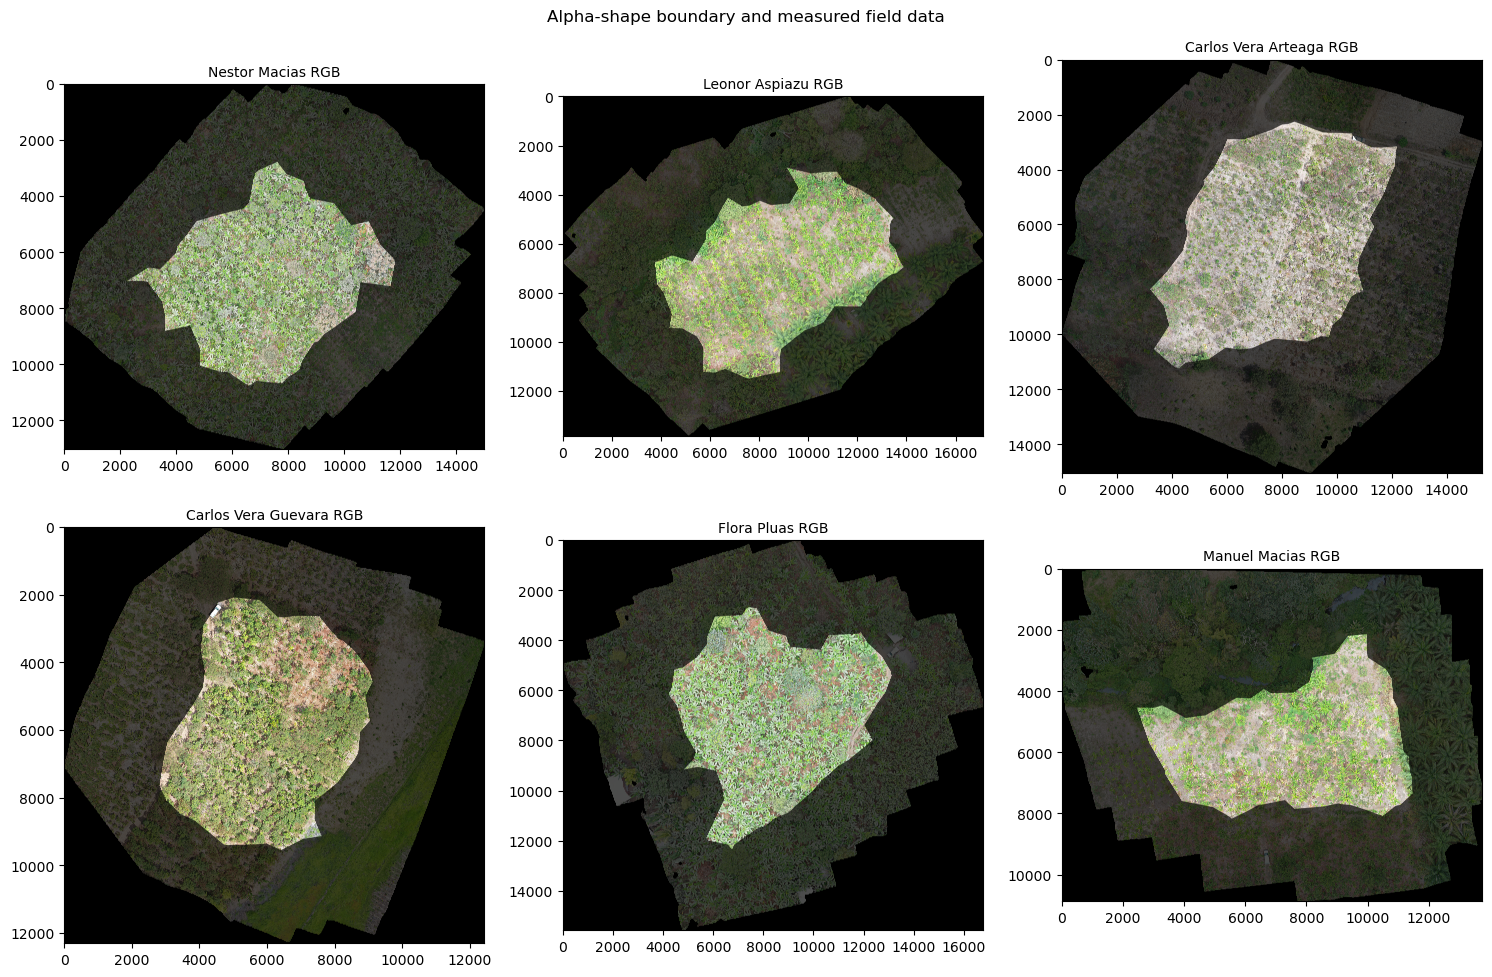

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle("Alpha-shape boundary and measured field data")

# Loop over the sites and plot the images
# axs.flat is used to flatten the 2D array of axes, why? because we want to loop over them in a single loop
for site, ax in zip(images.keys(), axs.flat):
    ax.imshow(images[site])
    ax.imshow(images_cropped[site], alpha=0.7)
    ax.set_title(site, fontsize=10)
# tight_layout() is used to adjust the subplots so that they fit into the figure area, pad=1 means that the padding between the subplots is 1 unit
fig.tight_layout(pad=1)
plt.show()  

## Saving the newly cropped images as .tif files

Processing image for site: Nestor Macias RGB
Image saved successfully at full_reforestree_data_dropbox/wwf_ecuador/RGB Orthomosaics/Cropped/Nestor Macias RGB_cropped.tif


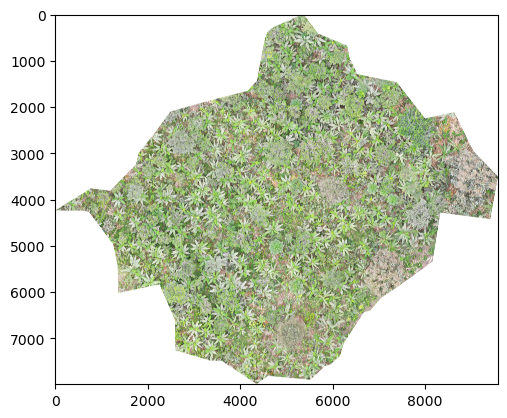

Processing image for site: Leonor Aspiazu RGB
Image saved successfully at full_reforestree_data_dropbox/wwf_ecuador/RGB Orthomosaics/Cropped/Leonor Aspiazu RGB_cropped.tif


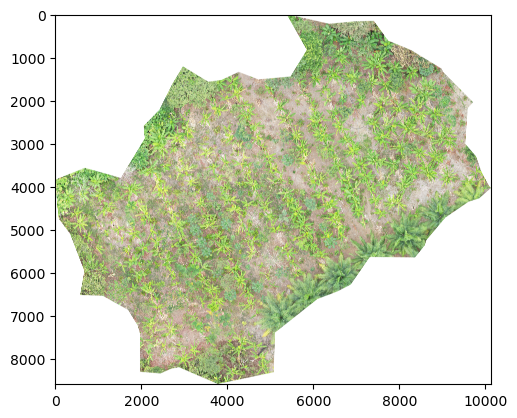

Processing image for site: Carlos Vera Arteaga RGB
Image saved successfully at full_reforestree_data_dropbox/wwf_ecuador/RGB Orthomosaics/Cropped/Carlos Vera Arteaga RGB_cropped.tif


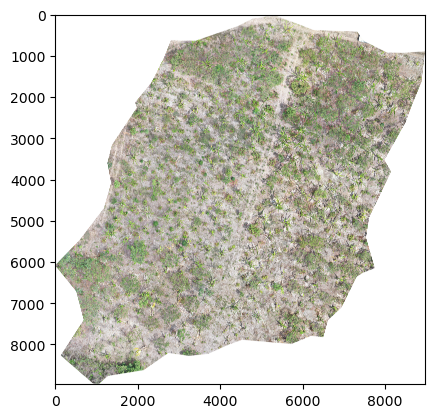

Processing image for site: Carlos Vera Guevara RGB
Image saved successfully at full_reforestree_data_dropbox/wwf_ecuador/RGB Orthomosaics/Cropped/Carlos Vera Guevara RGB_cropped.tif


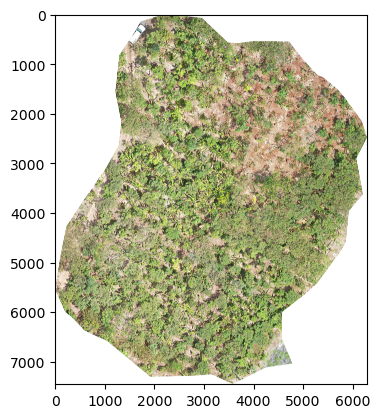

Processing image for site: Flora Pluas RGB
Image saved successfully at full_reforestree_data_dropbox/wwf_ecuador/RGB Orthomosaics/Cropped/Flora Pluas RGB_cropped.tif


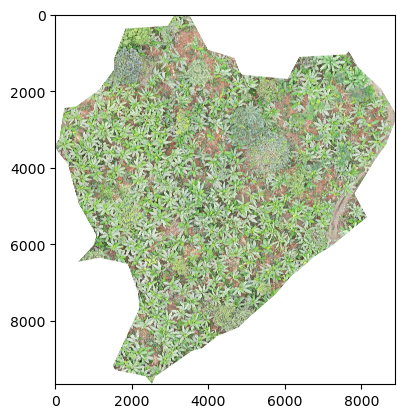

Processing image for site: Manuel Macias RGB
Image saved successfully at full_reforestree_data_dropbox/wwf_ecuador/RGB Orthomosaics/Cropped/Manuel Macias RGB_cropped.tif


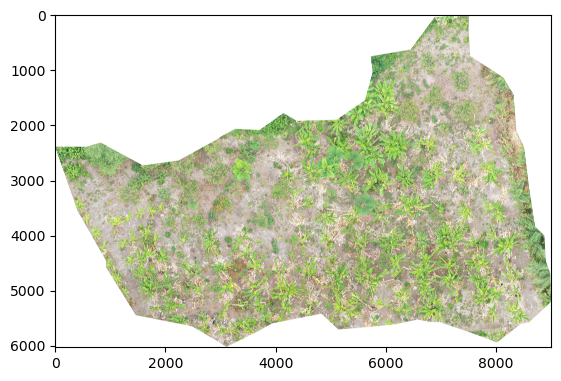

In [29]:
import os

for site, img_cropped in images_cropped.items():
    print(f"Processing image for site: {site}")
    # Create a new directory to save the newly cropped .tif images
    os.makedirs(f'{path_to_data}wwf_ecuador/RGB Orthomosaics/Cropped', exist_ok=True)
    new_img_path = path_to_data + 'wwf_ecuador/RGB Orthomosaics/Cropped/{}_cropped.tif'.format(site)

    # Get the original image's transform and CRS information
    with rasterio.open(path_to_data + 'wwf_ecuador/RGB Orthomosaics/{}.tif'.format(site)) as src:
        # get the transform and crs of the original image, will be used to save the new image
        # what is transform? https://rasterio.readthedocs.io/en/latest/topics/georeferencing.html
        transform = src.transform
        crs = src.crs

    # Replace all 0s (black) with 255s (white)
    img_cropped = np.where(img_cropped==0, 255, img_cropped)

    # Calculate bounding box of non-white pixels
    rows = np.any(img_cropped != 255, axis=1)
    cols = np.any(img_cropped != 255, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Crop the image based on the bounding box
    img_cropped = img_cropped[rmin:rmax+1, cmin:cmax+1, :]

    # Open a new .tif file in write mode
    # we are creating the cropped raster object here
    with rasterio.open(new_img_path, 'w', driver='GTiff',
                       height=img_cropped.shape[0], width=img_cropped.shape[1],
                       count=3, dtype=img_cropped.dtype,
                       crs=crs, transform=transform) as dst:
        # Write the cropped image to the new .tif file
        dst.write(img_cropped.transpose((2, 0, 1)))

    print(f"Image saved successfully at {new_img_path}")

    # Open and display the saved .tif image
    with rasterio.open(new_img_path) as src:
        img = src.read()  # read all bands
        # before opening always shifts the channels to the last dimension
        img = np.moveaxis(img, 0, -1)
        plt.imshow(img)
        plt.show()